In [1]:
import pandas as pd
base = pd.read_csv('petr4.csv')
base = base.dropna()

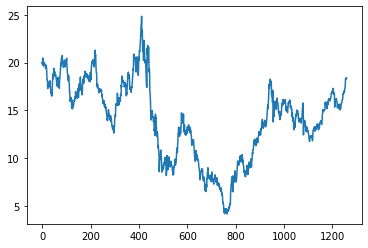

In [2]:
base = base.iloc[:, 1].values
import matplotlib.pyplot as plt
plt.plot(base)

In [3]:
periodos = 30
previsao_futura = 1 # horizonte

X = base[0:(len(base) - (len(base) % periodos))]
X_batches = X.reshape(-1, periodos, 1)

y = base[1:(len(base) - (len(base) % periodos)) + previsao_futura]
y_batches = y.reshape(-1, periodos, 1)

X_teste = base[-(periodos + previsao_futura):]
X_teste = X_teste[:periodos]
X_teste = X_teste.reshape(-1, periodos, 1)
y_teste = base[-(periodos):]
y_teste = y_teste.reshape(-1, periodos, 1)

In [4]:
X_batches.shape, y_batches.shape, X_teste.shape, y_teste.shape

((41, 30, 1), (41, 30, 1), (1, 30, 1), (1, 30, 1))

In [5]:
import tensorflow as tf
tf.random.set_seed(42)

tf.__version__

'2.3.0'

In [6]:
entradas = 1
neuronios_oculta = 100
neuronios_saida = 1

Segundo https://www.tensorflow.org/guide/migrate#a_note_on_slim_contriblayers, o módulo `tf.contrib` foi descontinuado. 

# Usando RNN Simples

In [7]:
class Model(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.rnn = tf.keras.layers.SimpleRNN(units = neuronios_oculta, activation = 'relu', return_sequences = True)
        self.dense = tf.keras.layers.Dense(units = neuronios_saida)
    
    def call(self, inputs):
        x = self.rnn(inputs)
        x = self.dense(x)

        return x

In [8]:
model = Model()
otimizador = tf.keras.optimizers.Adam(learning_rate = 0.001)

for epoca in range(1000):
    with tf.GradientTape() as tape:
        out = model(X_batches)
        erro = tf.keras.losses.mean_squared_error(out, y_batches)
    
    # Uma das vantagens de escrever o modelo como uma instância de `tf.keras.Model`
    # é que podemos recuperar a `var_list` com `model.trainable_variables`
    gradientes = tape.gradient(erro, model.trainable_variables)
    otimizador.apply_gradients(zip(gradientes, model.trainable_variables))

    if epoca % 100 == 0:
        print(epoca + 1, ' erro: ', tf.reduce_mean(erro).numpy())


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1  erro:  123.5112094878818
101  erro:  2.248128455076205
201  erro:  0.5604268391397469
301  erro:  0.205570338580093
401  erro:  0.1896733230235893
501  erro:  0.18783501334466418
601  erro:  0.18582517945198102
701  erro:  0.17941135761929575
801  erro:  0.17474555879383397
901  erro:  0.1714701838739803


In [9]:
previsoes = model(X_teste)
previsoes

<tf.Tensor: shape=(1, 30, 1), dtype=float32, numpy=
array([[[15.413541],
        [15.711014],
        [15.127745],
        [15.082155],
        [15.156298],
        [15.110255],
        [15.483986],
        [15.411455],
        [15.449482],
        [15.801123],
        [15.79926 ],
        [15.957372],
        [16.135756],
        [16.200783],
        [16.229218],
        [16.45593 ],
        [16.770096],
        [16.770367],
        [16.778345],
        [16.990208],
        [16.941383],
        [16.918566],
        [17.005772],
        [17.26142 ],
        [17.370527],
        [17.882738],
        [18.317354],
        [18.394016],
        [18.346802],
        [18.37886 ]]], dtype=float32)>

In [10]:
import numpy as np
y_teste2 = np.ravel(y_teste)

In [11]:
previsoes2 = np.ravel(previsoes.numpy())

In [12]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_teste2, previsoes2)
mae

0.17386122467447945

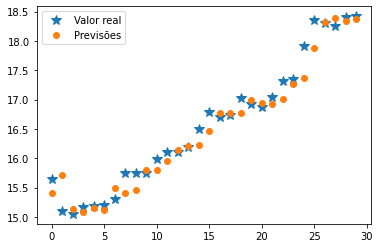

In [13]:
plt.plot(y_teste2, '*', markersize = 10, label = 'Valor real')
plt.plot(previsoes2, 'o', label = 'Previsões')
plt.legend()

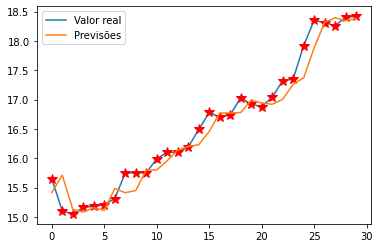

In [14]:
plt.plot(y_teste2, label = 'Valor real')
plt.plot(y_teste2, 'w*', markersize = 10, color = 'red')
plt.plot(previsoes2, label = 'Previsões')
plt.legend()

# Usando LSTM

In [15]:
class Model(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.lstm = tf.keras.layers.LSTM(units = neuronios_oculta, activation = 'relu', return_sequences = True)
        self.dense = tf.keras.layers.Dense(units = neuronios_saida)
    
    def call(self, inputs):
        x = self.lstm(inputs)
        x = self.dense(x)

        return x

In [16]:
model = Model()
otimizador = tf.keras.optimizers.Adam(learning_rate = 0.001)

for epoca in range(1000):
    with tf.GradientTape() as tape:
        out = model(X_batches)
        erro = tf.keras.losses.mean_squared_error(out, y_batches)
    
    # Uma das vantagens de escrever o modelo como uma instância de `tf.keras.Model`
    # é que podemos recuperar a `var_list` com `model.trainable_variables`
    gradientes = tape.gradient(erro, model.trainable_variables)
    otimizador.apply_gradients(zip(gradientes, model.trainable_variables))

    if epoca % 100 == 0:
        print(epoca + 1, ' erro: ', tf.reduce_mean(erro).numpy())


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1  erro:  146.02638828273203
101  erro:  6.062502630294103
201  erro:  2.238208858393262
301  erro:  0.4434352489726186
401  erro:  0.19654635220640773
501  erro:  0.17794733291115375
601  erro:  0.17532183391857603
701  erro:  0.17234733320388101
801  erro:  0.1585406379463371
901  erro:  0.1463977553090012


In [17]:
previsoes = model(X_teste)
previsoes

<tf.Tensor: shape=(1, 30, 1), dtype=float32, numpy=
array([[[15.403061 ],
        [15.666862 ],
        [15.149902 ],
        [15.173392 ],
        [15.292043 ],
        [15.23158  ],
        [15.179492 ],
        [15.2367525],
        [15.598362 ],
        [15.69919  ],
        [15.770866 ],
        [15.936618 ],
        [16.116943 ],
        [16.128193 ],
        [16.18997  ],
        [16.48451  ],
        [16.78791  ],
        [16.82304  ],
        [16.95389  ],
        [17.171616 ],
        [17.025639 ],
        [17.00232  ],
        [16.81711  ],
        [17.116934 ],
        [17.500856 ],
        [18.163198 ],
        [18.560755 ],
        [18.66575  ],
        [18.321114 ],
        [17.592762 ]]], dtype=float32)>

In [18]:
y_teste2 = np.ravel(y_teste)
previsoes2 = np.ravel(previsoes.numpy())
mae = mean_absolute_error(y_teste2, previsoes2)
mae

0.21834127816772503

# Múltiplas camadas LSTM

O construtor para empilhar células com estrutura de RNN deve ser `tf.keras.layers.StackedRNNCells`, que depois deve ser consolidada em uma camada usando o construtor `tf.keras.layers.RNN`, conforme exemplo em https://www.tensorflow.org/api_docs/python/tf/keras/layers/StackedRNNCells#examples

In [19]:
class Model(tf.keras.Model):
    def __init__(self):
        super().__init__()
        lstms = [tf.keras.layers.LSTMCell(units = neuronios_oculta, activation = 'relu') for _ in range(4)]
        stacked_lstm = tf.keras.layers.StackedRNNCells(cells = lstms)
        self.lstm_layer = tf.keras.layers.RNN(cell = stacked_lstm, return_sequences = True)
        self.dense = tf.keras.layers.Dense(units = neuronios_saida)
    
    def call(self, inputs):
        x = self.lstm_layer(inputs)
        x = self.dense(x)

        return x

In [20]:
model = Model()
otimizador = tf.keras.optimizers.Adam(learning_rate = 0.001)

for epoca in range(1000):
    with tf.GradientTape() as tape:
        out = model(X_batches)
        erro = tf.keras.losses.mean_squared_error(out, y_batches)
    
    # Uma das vantagens de escrever o modelo como uma instância de `tf.keras.Model`
    # é que podemos recuperar a `var_list` com `model.trainable_variables`
    gradientes = tape.gradient(erro, model.trainable_variables)
    otimizador.apply_gradients(zip(gradientes, model.trainable_variables))

    if epoca % 100 == 0:
        print(epoca + 1, ' erro: ', tf.reduce_mean(erro).numpy())


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1  erro:  205.58804442689694
101  erro:  16.171051754821026
201  erro:  4.739298619874494
301  erro:  0.8384997545823752
401  erro:  0.827148930423916
501  erro:  0.4789546910498136
601  erro:  0.36720645315388534
701  erro:  0.3121628280684808
801  erro:  0.2656845797621961
901  erro:  0.3364047531026066


In [21]:
previsoes = model(X_teste)
previsoes

<tf.Tensor: shape=(1, 30, 1), dtype=float32, numpy=
array([[[15.462924],
        [15.465266],
        [15.520151],
        [15.433026],
        [15.317963],
        [15.228615],
        [15.136157],
        [15.272528],
        [15.387009],
        [15.585243],
        [15.845898],
        [15.909593],
        [16.106228],
        [16.012682],
        [16.001709],
        [16.222486],
        [16.390627],
        [16.426296],
        [16.331596],
        [16.398088],
        [16.47245 ],
        [16.401989],
        [16.390467],
        [16.749777],
        [16.923624],
        [16.886076],
        [17.311932],
        [17.796661],
        [18.242445],
        [18.51887 ]]], dtype=float32)>

In [22]:
y_teste2 = np.ravel(y_teste)
previsoes2 = np.ravel(previsoes.numpy())
mae = mean_absolute_error(y_teste2, previsoes2)
mae

0.42639547684122736

# Com dropout

In [23]:
class Model(tf.keras.Model):
    def __init__(self):
        super().__init__()
        lstms = [tf.keras.layers.LSTMCell(units = neuronios_oculta, activation = 'relu') for _ in range(4)]
        stacked_lstm = tf.keras.layers.StackedRNNCells(cells = lstms)
        self.lstm_layer = tf.keras.layers.RNN(cell = stacked_lstm, return_sequences = True)
        self.dropout = tf.keras.layers.Dropout(rate = 0.1)
        self.dense = tf.keras.layers.Dense(units = neuronios_saida)
    
    def call(self, inputs):
        x = self.lstm_layer(inputs)
        x = self.dropout(x)
        x = self.dense(x)

        return x

In [24]:
model = Model()
otimizador = tf.keras.optimizers.Adam(learning_rate = 0.001)

for epoca in range(1000):
    with tf.GradientTape() as tape:
        out = model(X_batches)
        erro = tf.keras.losses.mean_squared_error(out, y_batches)
    
    # Uma das vantagens de escrever o modelo como uma instância de `tf.keras.Model`
    # é que podemos recuperar a `var_list` com `model.trainable_variables`
    gradientes = tape.gradient(erro, model.trainable_variables)
    otimizador.apply_gradients(zip(gradientes, model.trainable_variables))

    if epoca % 100 == 0:
        print(epoca + 1, ' erro: ', tf.reduce_mean(erro).numpy())


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1  erro:  221.33118085912352
101  erro:  14.026478847603745
201  erro:  1.018236887904483
301  erro:  0.3083717630357303
401  erro:  0.32749422631554365
501  erro:  0.15093164526284855
601  erro:  0.13895919378277818
701  erro:  0.13676955136024457
801  erro:  0.20022988639810987
901  erro:  0.11445338707193443


In [25]:
previsoes = model(X_teste)
previsoes

<tf.Tensor: shape=(1, 30, 1), dtype=float32, numpy=
array([[[15.181871 ],
        [15.711775 ],
        [15.232873 ],
        [15.356727 ],
        [15.2214775],
        [15.217579 ],
        [15.231234 ],
        [15.133102 ],
        [15.3503   ],
        [15.556724 ],
        [15.72226  ],
        [15.724763 ],
        [15.91631  ],
        [16.041918 ],
        [16.023273 ],
        [16.440226 ],
        [16.685778 ],
        [16.788527 ],
        [16.681759 ],
        [17.07559  ],
        [16.665295 ],
        [17.420763 ],
        [16.687757 ],
        [17.861105 ],
        [16.618387 ],
        [17.55171  ],
        [16.766592 ],
        [18.803743 ],
        [17.391253 ],
        [17.757595 ]]], dtype=float32)>

In [26]:
y_teste2 = np.ravel(y_teste)
previsoes2 = np.ravel(previsoes.numpy())
mae = mean_absolute_error(y_teste2, previsoes2)
mae

0.4247350924357098

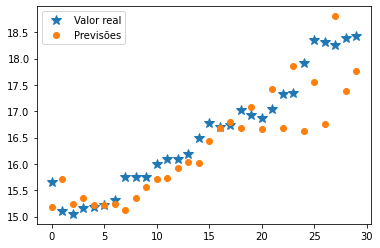

In [27]:
plt.plot(y_teste2, '*', markersize = 10, label = 'Valor real')
plt.plot(previsoes2, 'o', label = 'Previsões')
plt.legend()